In [2]:
!pip install labelme tensorflow opencv-python matplotlib albumentations

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import os
import time
import uuid
import cv2

In [4]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [40]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [41]:
!labelme

^C


In [5]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [6]:
#avoid OOM errors by setting gpu memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [7]:
tf.config.list_physical_devices('GPU')

[]

In [8]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg',shuffle=False)

In [9]:
images.as_numpy_iterator().next()    #gives complete path

b'data\\images\\aedba4f8-ea75-11ee-8944-005056c00008.jpg'

In [10]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [11]:
images = images.map(load_image)

In [12]:
images.as_numpy_iterator().next()

array([[[184, 204, 229],
        [184, 204, 229],
        [184, 204, 231],
        ...,
        [ 88,  31,  37],
        [ 93,  34,  38],
        [ 96,  37,  41]],

       [[183, 203, 228],
        [184, 206, 230],
        [186, 206, 233],
        ...,
        [ 90,  33,  39],
        [ 92,  36,  39],
        [ 98,  39,  43]],

       [[185, 206, 233],
        [185, 209, 235],
        [189, 210, 237],
        ...,
        [ 90,  35,  38],
        [ 94,  38,  41],
        [ 97,  41,  44]],

       ...,

       [[ 81,  91,  90],
        [ 83,  93,  92],
        [ 84,  94,  93],
        ...,
        [ 25,  15,  14],
        [ 24,  14,  13],
        [ 25,  13,  13]],

       [[ 83,  91,  93],
        [ 84,  92,  94],
        [ 84,  94,  95],
        ...,
        [ 24,  15,  16],
        [ 24,  14,  13],
        [ 24,  14,  13]],

       [[ 83,  91,  93],
        [ 84,  92,  94],
        [ 83,  93,  94],
        ...,
        [ 22,  16,  16],
        [ 24,  14,  13],
        [ 23,  13,  12]]

In [13]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

In [14]:
image_generator = images.batch(4).as_numpy_iterator()  #group of 4 images

In [15]:
plot_images = image_generator.next()

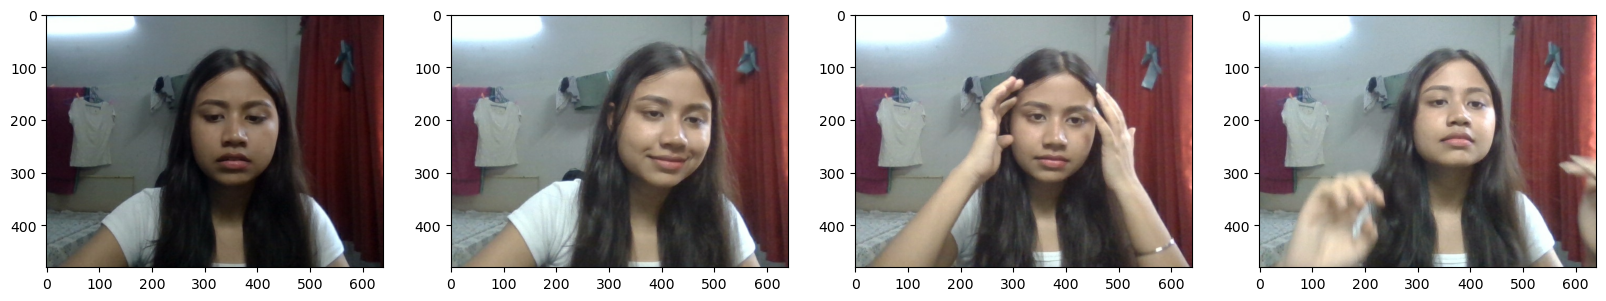

In [16]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

In [17]:
90*.7 # 63 to train

62.99999999999999

In [18]:
90*.15 # 14 and 13 to test and val

13.5

In [19]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

In [20]:
import albumentations as alb

In [21]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [22]:
img=cv2.imread(os.path.join('data','train','images','af88edd9-ea75-11ee-9bcc-005056c00008.jpg'))

In [23]:
img

array([[[250, 248, 224],
        [250, 248, 224],
        [251, 248, 227],
        ...,
        [ 46,  65, 140],
        [ 49,  67, 144],
        [ 51,  69, 146]],

       [[254, 251, 230],
        [254, 251, 230],
        [254, 251, 230],
        ...,
        [ 47,  66, 141],
        [ 50,  68, 145],
        [ 52,  70, 147]],

       [[255, 255, 235],
        [255, 255, 235],
        [255, 255, 235],
        ...,
        [ 47,  66, 139],
        [ 48,  69, 144],
        [ 51,  72, 147]],

       ...,

       [[122, 129, 124],
        [121, 128, 123],
        [120, 127, 122],
        ...,
        [ 31,  27,  62],
        [ 31,  27,  62],
        [ 31,  27,  62]],

       [[120, 127, 122],
        [120, 127, 122],
        [117, 126, 123],
        ...,
        [ 32,  28,  63],
        [ 32,  29,  61],
        [ 32,  29,  61]],

       [[119, 126, 121],
        [118, 125, 120],
        [117, 126, 123],
        ...,
        [ 33,  29,  64],
        [ 33,  30,  62],
        [ 33,  30,  62]]

In [24]:
with open(os.path.join('data', 'train', 'labels', 'af88edd9-ea75-11ee-9bcc-005056c00008.json'), 'r') as f:
    label = json.load(f)

In [25]:
label['shapes'][0]['points']

[[265.8333333333333, 67.77777777777777],
 [434.72222222222223, 323.8888888888889]]

In [26]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [27]:
coords

[265.8333333333333, 67.77777777777777, 434.72222222222223, 323.8888888888889]

In [28]:
coords = list(np.divide(coords, [640,480,640,480]))

In [29]:
coords

[0.4153645833333333,
 0.1412037037037037,
 0.6792534722222222,
 0.6747685185185186]

In [30]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [31]:
augmented.keys()

dict_keys(['image', 'bboxes', 'class_labels'])

In [32]:
augmented['image'].shape

(450, 450, 3)

In [33]:
augmented['bboxes'][0][2:]

(0.7203703703703704, 0.6664197530864198)

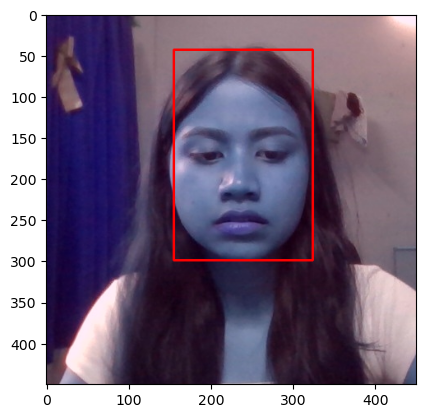

In [34]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

In [35]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

In [36]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [37]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [38]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [39]:
train_images.as_numpy_iterator().next()

array([[[0.98970586, 0.997549  , 0.9936274 ],
        [0.98970586, 0.997549  , 0.9936274 ],
        [0.98970586, 0.997549  , 0.9936274 ],
        ...,
        [0.40637255, 0.4504902 , 0.44411764],
        [0.3893995 , 0.42861518, 0.42726716],
        [0.38658088, 0.40373775, 0.41550246]],

       [[0.99607843, 1.        , 1.        ],
        [0.99607843, 1.        , 1.        ],
        [0.99607843, 1.        , 1.        ],
        ...,
        [0.4161152 , 0.45533088, 0.45238972],
        [0.40894607, 0.44117647, 0.4485907 ],
        [0.40067402, 0.40968138, 0.4266544 ]],

       [[0.99215686, 1.        , 0.99607843],
        [0.99215686, 1.        , 0.99607843],
        [0.99215686, 1.        , 0.99607843],
        ...,
        [0.42463234, 0.46384802, 0.4677696 ],
        [0.41911766, 0.44019607, 0.45147058],
        [0.3175858 , 0.3146446 , 0.34405637]],

       ...,

       [[0.35612744, 0.37965685, 0.36397058],
        [0.34595588, 0.38125   , 0.36164215],
        [0.34797794, 0

In [40]:

def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [41]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [42]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [43]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [44]:

train_images.as_numpy_iterator().next()

array([[[0.98970586, 0.997549  , 0.9936274 ],
        [0.98970586, 0.997549  , 0.9936274 ],
        [0.98970586, 0.997549  , 0.9936274 ],
        ...,
        [0.40637255, 0.4504902 , 0.44411764],
        [0.3893995 , 0.42861518, 0.42726716],
        [0.38658088, 0.40373775, 0.41550246]],

       [[0.99607843, 1.        , 1.        ],
        [0.99607843, 1.        , 1.        ],
        [0.99607843, 1.        , 1.        ],
        ...,
        [0.4161152 , 0.45533088, 0.45238972],
        [0.40894607, 0.44117647, 0.4485907 ],
        [0.40067402, 0.40968138, 0.4266544 ]],

       [[0.99215686, 1.        , 0.99607843],
        [0.99215686, 1.        , 0.99607843],
        [0.99215686, 1.        , 0.99607843],
        ...,
        [0.42463234, 0.46384802, 0.4677696 ],
        [0.41911766, 0.44019607, 0.45147058],
        [0.3175858 , 0.3146446 , 0.34405637]],

       ...,

       [[0.35612744, 0.37965685, 0.36397058],
        [0.34595588, 0.38125   , 0.36164215],
        [0.34797794, 0

In [45]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.508 , 0.1355, 0.915 , 0.7144], dtype=float16))

In [46]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3780, 3780, 840, 840, 780, 780)

In [47]:
train = tf.data.Dataset.zip((train_images, train_labels))#combining
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4) 

In [48]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [49]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [50]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

In [51]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.633 , 0.2556, 1.    , 0.862 ],
        [0.2656, 0.3591, 0.7817, 0.9233],
        [0.2812, 0.3083, 0.7046, 0.863 ],
        [0.641 , 0.268 , 1.    , 0.8877],
        [0.4043, 0.3396, 0.75  , 0.7456],
        [0.687 , 0.2993, 1.    , 0.835 ],
        [0.    , 0.0553, 0.4907, 0.649 ],
        [0.2249, 0.2908, 0.642 , 0.897 ]], dtype=float16))

In [52]:
data_samples = train.as_numpy_iterator()

In [53]:

res = data_samples.next()

error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - img marked as output argument, but provided NumPy array marked as readonly
>  - Expected Ptr<cv::UMat> for argument 'img'
>  - img marked as output argument, but provided NumPy array marked as readonly
>  - Expected Ptr<cv::UMat> for argument 'img'


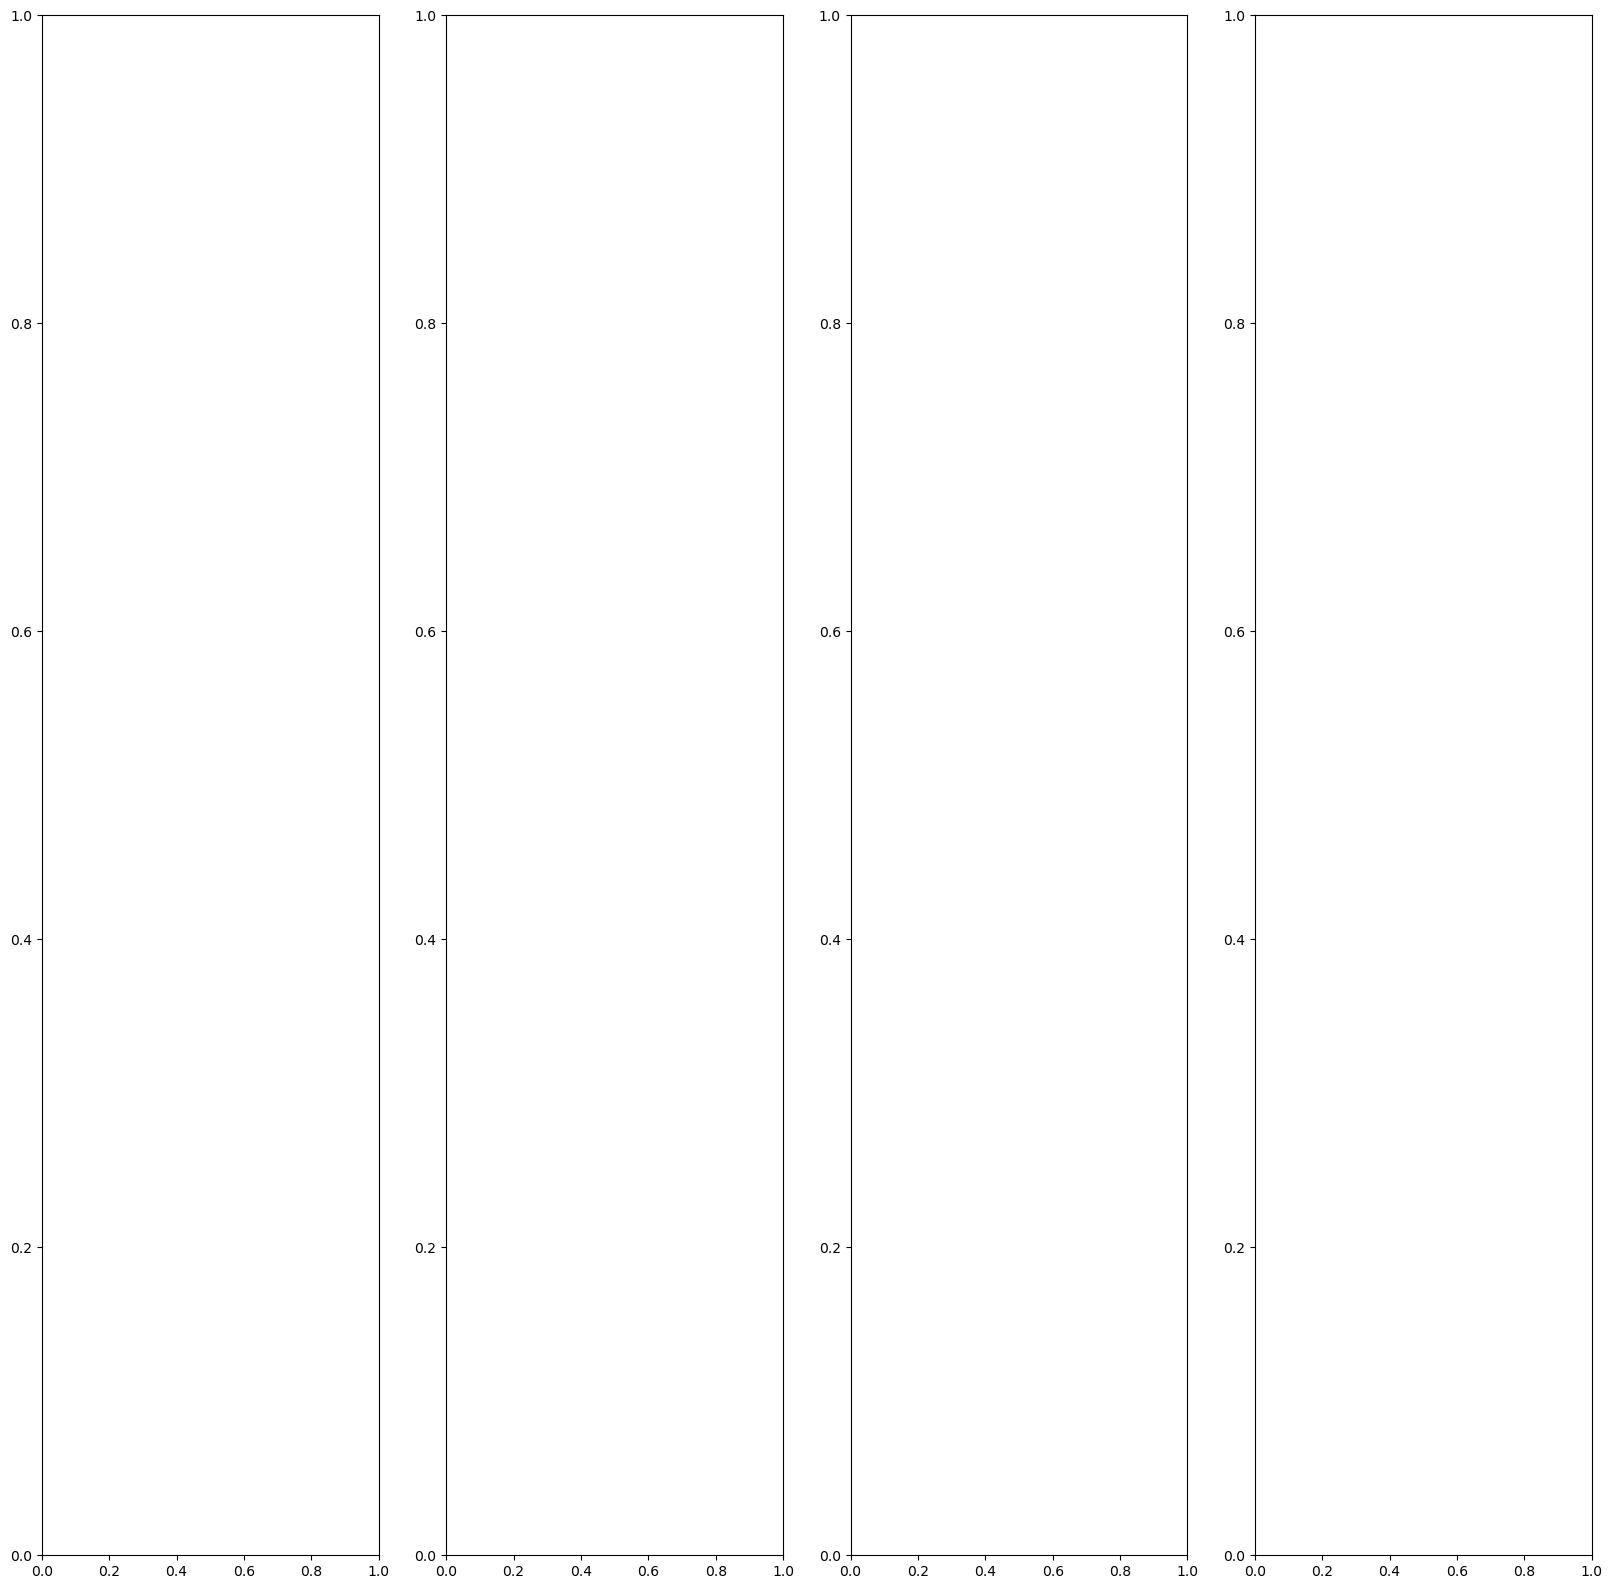

In [54]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)